In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
def camera_Calibration(image_path_list,num_corners=(9,6),vs=False):
    nx = num_corners[0]
    ny = num_corners[1]
    objc = np.zeros((nx*ny, 3), dtype=np.float32)
    xx, yy = np.meshgrid(np.arange(nx), np.arange(ny))
    objc[:,:2] = np.array([xx.ravel(), yy.ravel()]).T

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    for img_path in image_path_list:
        img = mpimg.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray_img, num_corners, None)
        if ret == True:
            objpoints.append(objc)
            imgpoints.append(corners)
            if vs == True:
                cv2.drawChessboardCorners(img, num_corners, corners, ret)
                plt.imshow(img)
                plt.show()
    img = mpimg.imread(img_path_list[0])
    img_size = img.shape[:2]
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,img_size, None,None)
    return mtx, dist

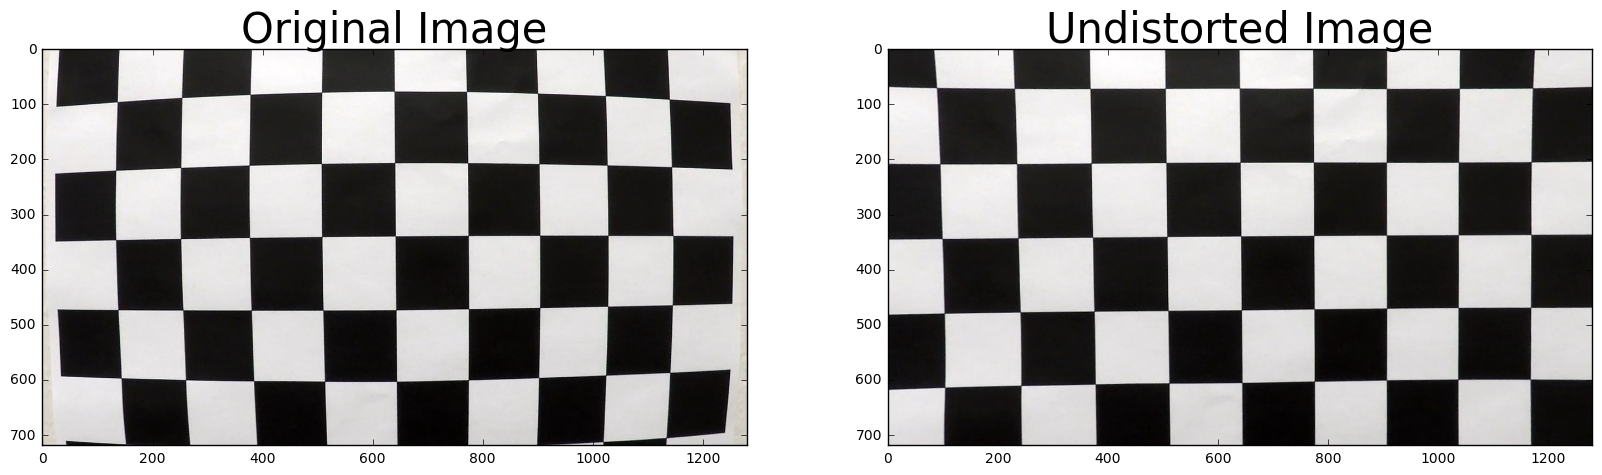

In [3]:
img_path_list = glob.glob("./camera_cal/calibration*.jpg")
mtx, dist = camera_Calibration(img_path_list,(9,6))
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "./output_images/wide_dist_pickle.p", "wb" ) )


del mtx,dist
with open( "./output_images/wide_dist_pickle.p", "rb" ) as f:
    data = pickle.load(f)   
mtx = data['mtx']
dist = data['dist']

img = mpimg.imread(img_path_list[0])
dst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
f.savefig("./output_images/Calibration_result.png")

In [4]:
def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [13]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''
    # Grayscale
    # Apply cv2.Sobel()
    # Take the absolute value of the output from cv2.Sobel()
    # Scale the result to an 8-bit range (0-255)
    # Apply lower and upper thresholds
    # Create binary_output
    '''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0,255)):
    '''
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    '''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    magnitude = np.sqrt(np.square(abs_sobelx) + np.square(abs_sobely))
    
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1 # Remove this line
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0., np.pi/2)):
    '''
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    '''
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(dir_gradient)
    binary_output[(dir_gradient >= thresh[0]) & (dir_gradient <= thresh[1])] = 1
    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(image, channel='h',thresh=(0, 255)):
    '''
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    '''
    hls_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    if channel == 'h':
        c_img = hls_img[:,:,0]
    elif channel == 'l':
        c_img = hls_img[:,:,1]
    elif channel == 's':
        c_img = hls_img[:,:,2]   
    else:
        c_img = hls_img[:,:,2]
    binary_output = np.zeros_like(c_img)
    binary_output[(c_img >= thresh[0]) & (c_img <= thresh[1])] = 1
    return binary_output

In [14]:
def gradient_Threshold(img,thresh_dic):    
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=thresh_dic['gradx'])
    s_binary = hls_select(img, channel= 's', thresh=thresh_dic['s'])
    l_binary = hls_select(img, channel= 'l', thresh=thresh_dic['l'])
    
    combined = np.zeros_like(gradx)
    combined[(gradx == 1) | (l_binary==1) &(s_binary==1)] = 1
    return combined

In [39]:
def perspective_Transform(image, src = None, dst = None):
    '''
    img_size = (img.shape[1], img.shape[0])
    if src is None:
        src = np.array([[585. /1280.*img_size[1], 455./720.*img_size[0]],
                        [705. /1280.*img_size[1], 455./720.*img_size[0]],
                        [1130./1280.*img_size[1], 720./720.*img_size[0]],
                        [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
        
    if dst is None:
        dst = np.array([[300. /1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 100./720.*img_size[0]],
                        [1000./1280.*img_size[1], 720./720.*img_size[0]],
                        [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)
    '''     
    img_size = (image.shape[1], image.shape[0])
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]])

    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])   
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_image = cv2.warpPerspective(image, M, img_size , flags=cv2.INTER_LINEAR) 
    return M, Minv, warped_image
    

In [16]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.uint8(255* np.dstack((binary_warped, binary_warped, binary_warped))/np.max(binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###   
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) >= minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) >= minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return leftx, lefty, rightx, righty, out_img

In [17]:
def polyfit_using_prev_fit(prev_left_fit, prev_right_fit, binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    #left_lane_inds = None
    #right_lane_inds = None
    
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + 
                    prev_left_fit[2] - margin)) & (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + 
                    prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + 
                    prev_right_fit[2] - margin)) & (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + 
                    prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    return leftx, lefty, rightx, righty

In [18]:
def drawing_image(original_img, binary_warped, Minv,leftx, lefty, rightx, righty, left_curverad, right_curverad, center_dist):
    # Find our lane pixels first
    new_img = np.copy(original_img)
    
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.3, 0)
    
    curvature_text = "Curvature: Left = " + str(np.round(left_curverad, 2)) + ", Right = " + str(np.round(right_curverad, 2)) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (0,255,0), 2)
    deviation_text = "Lane deviation from center = {:.2f} m".format(center_dist) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, deviation_text, (30, 90), font, 1, (0,255,0), 2)
    return result

In [19]:
def measure_curvature_real(binary_warped):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    left_fitx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
    right_fitx = right_fitx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    ##### TO-DO: Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image   
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5 / np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = (1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5 / np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    car_position = binary_warped.shape[1]/2 * xm_per_pix
    h = binary_warped.shape[0] * ym_per_pix
    l_fit_x_int = left_fit_cr[0]*h**2 + left_fit_cr[1]*h + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*h**2 + right_fit_cr[1]*h + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center_dist = (car_position - lane_center_position)
    
    return left_curverad, right_curverad, center_dist

In [20]:
def test_measure_curvature_real(leftx, lefty, rightx, righty, binary_warped):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image   
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = (1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5 / np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = (1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5 / np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    car_position = binary_warped.shape[1]/2 * xm_per_pix
    h = binary_warped.shape[0] * ym_per_pix
    l_fit_x_int = left_fit_cr[0]*h**2 + left_fit_cr[1]*h + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*h**2 + right_fit_cr[1]*h + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center_dist = (car_position - lane_center_position)
    
    return left_curverad, right_curverad, center_dist

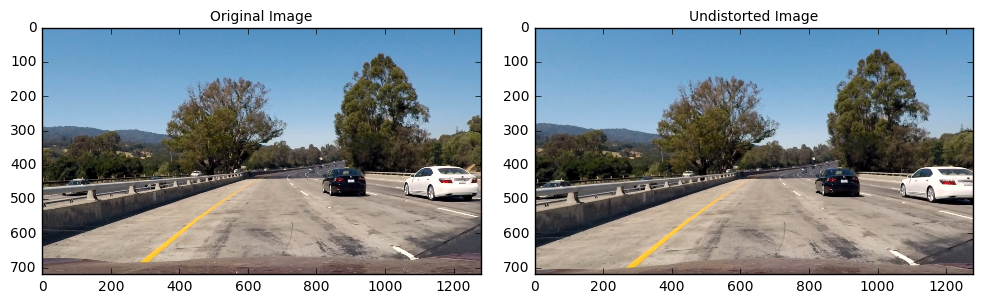

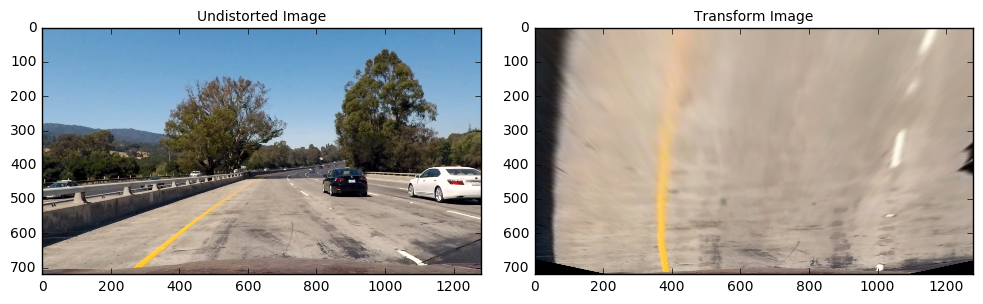

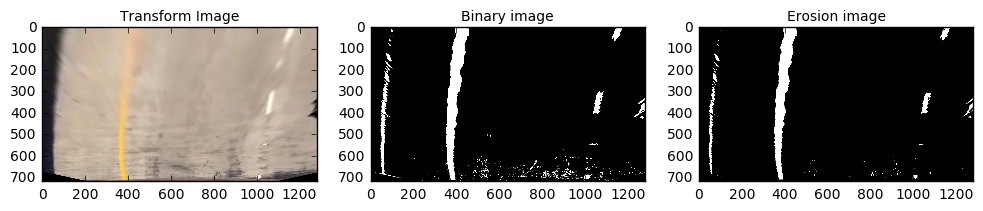

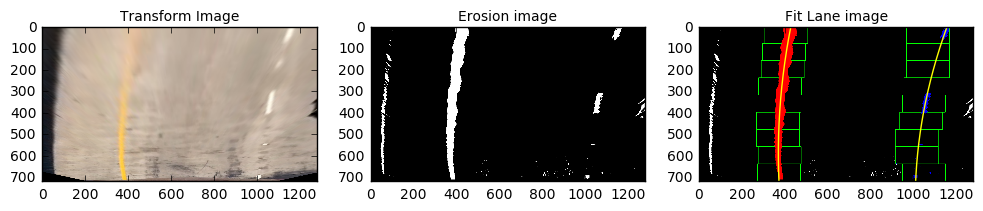

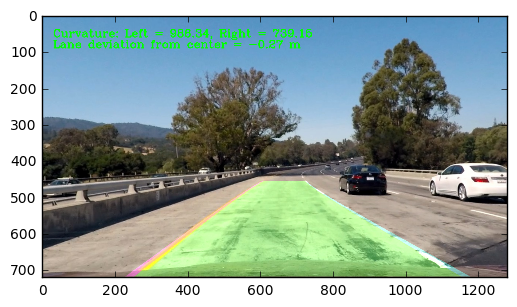

In [43]:
img_path_list = glob.glob("./test_images/*.jpg")
image = mpimg.imread(img_path_list[2])
undist_img = undistort(image, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=10)

ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=10)
#plt.subplots_adjust(left=0.5, right=1, top=1.9, bottom=0.)
f.savefig("./output_images/compare.png")
plt.show()

M, Minv, warped_image = perspective_Transform(undist_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(undist_img)
ax1.set_title('Undistorted Image', fontsize=10)

ax2.imshow(warped_image)
ax2.set_title('Transform Image', fontsize=10)
#plt.subplots_adjust(left=0.5, right=1, top=1.9, bottom=0.)
f.savefig("./output_images/Transform_compare.png")
plt.show()

thresh_dic = {'gradx':(20, 255),'s':(120, 255),'l':(40, 255)}
combined = gradient_Threshold(warped_image,thresh_dic)

kernel = np.ones((3,3),np.uint8)  
erosion = cv2.erode(combined,kernel,iterations = 1)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 8))
f.tight_layout()
ax1.imshow(warped_image)
ax1.set_title('Transform Image', fontsize=10)

ax2.imshow(combined, cmap='gray')
ax2.set_title('Binary image', fontsize=10)
#plt.subplots_adjust(left=0.5, right=1, top=1.9, bottom=0.)
ax3.imshow(erosion, cmap='gray')
ax3.set_title('Erosion image', fontsize=10)

f.savefig("./output_images/Binary_compare.png")
plt.show()
#dilation = cv2.dilate(erosion,kernel,iterations = 1)


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 8))
f.tight_layout()
ax1.imshow(warped_image)
ax1.set_title('Transform Image', fontsize=10)

ax2.imshow(erosion, cmap='gray')
ax2.set_title('Erosion image', fontsize=10)
#plt.subplots_adjust(left=0.5, right=1, top=1.9, bottom=0.)
leftx, lefty, rightx, righty,fit_image = fit_polynomial(erosion)
ax3.imshow(fit_image)
ax3.set_title('Fit Lane image', fontsize=10)
f.savefig("./output_images/fit_compare.png")
plt.show()

left_curverad, right_curverad, center_dist = test_measure_curvature_real(leftx, lefty, rightx, righty, erosion)
result_image =  drawing_image(undist_img, erosion, Minv,leftx, lefty, rightx, righty, left_curverad, right_curverad, center_dist)
plt.imshow(result_image)
plt.savefig("./output_images/result_img.png")
plt.show()


In [22]:
def process_image(image):
    global mtx, dist
    undist_img = undistort(image, mtx, dist)
    M, Minv, warped_image = perspective_Transform(undist_img)
    thresh_dic = {'gradx':(20, 255),'s':(120, 255),'l':(40, 255)}
    combined = gradient_Threshold(warped_image,thresh_dic)
    kernel = np.ones((3,3),np.uint8)  
    erosion = cv2.erode(combined,kernel,iterations = 1)
    #find_lane_pixels(erosion)
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(erosion)
    left_curverad, right_curverad, center_dist = test_measure_curvature_real(leftx, lefty, rightx, righty,erosion)
    result = drawing_image(undist_img, erosion, Minv, leftx, lefty, rightx, righty,left_curverad, right_curverad, center_dist)
    return result

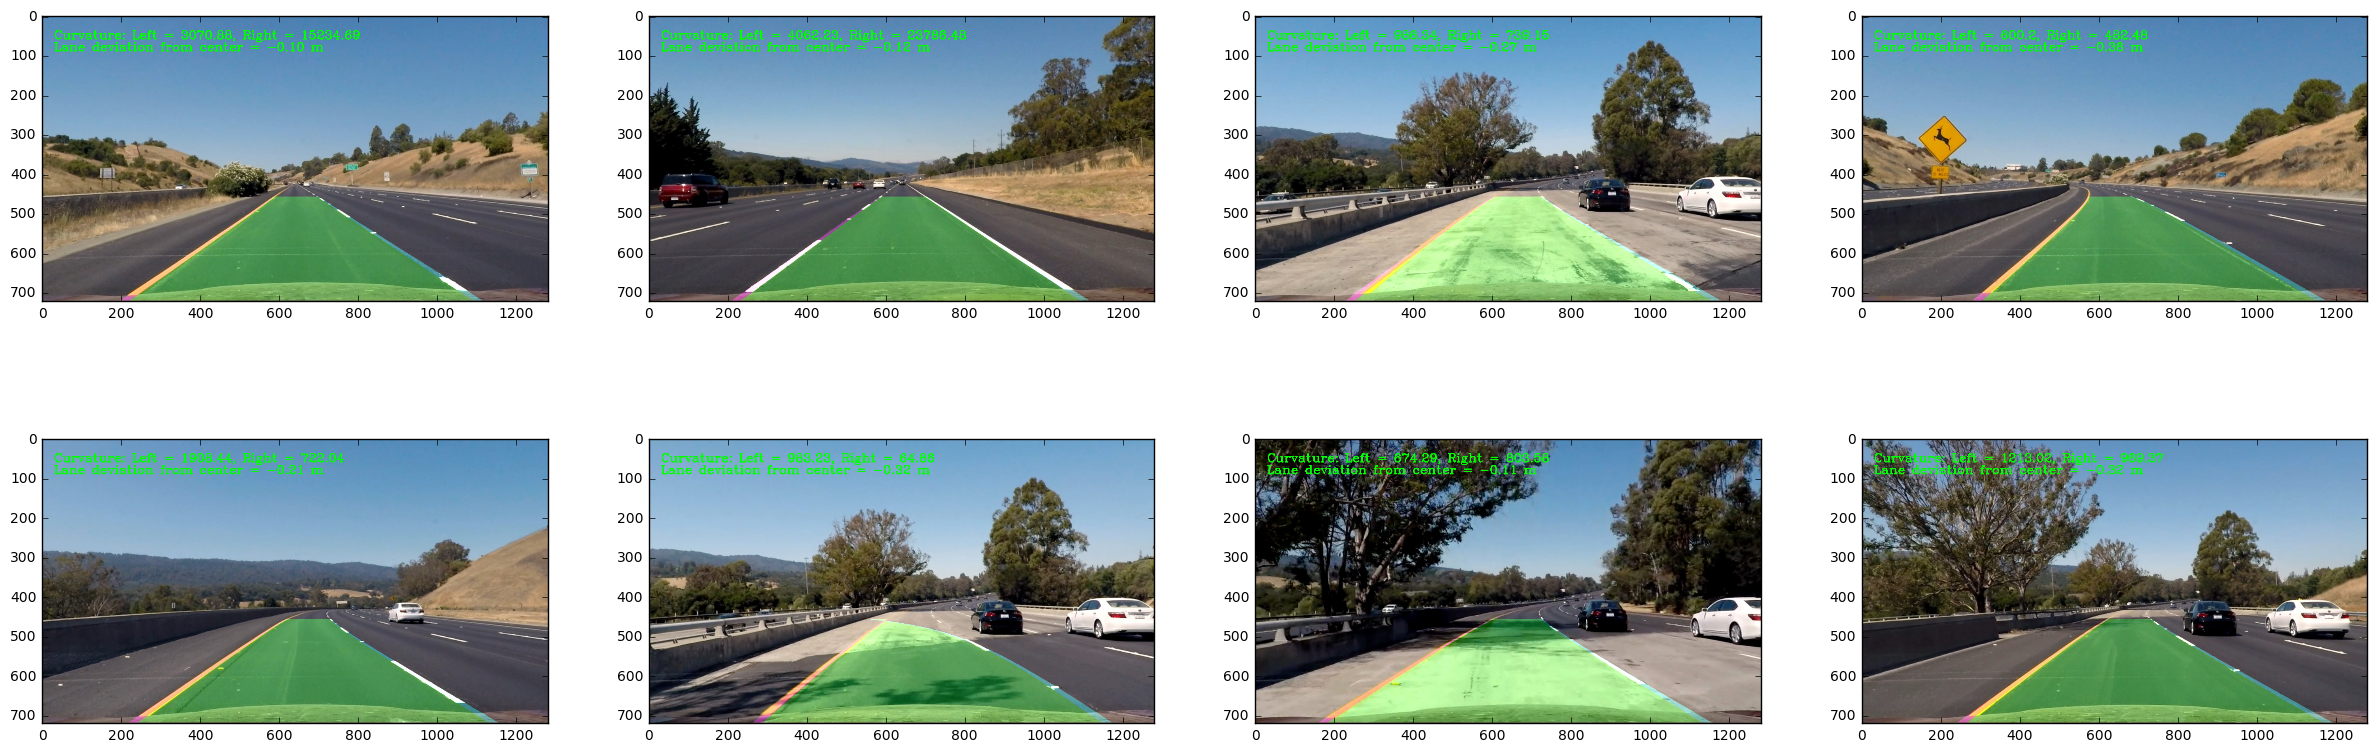

In [25]:
img_path_list = glob.glob("./test_images/*.jpg")
plt.figure(figsize=(30, 10))
for i, image_path in enumerate(img_path_list):
    image = mpimg.imread(image_path)
    result = process_image(image)
    plt.subplot(2, 4, i+1)
    plt.imshow(result)
plt.savefig("./output_images/all_result_img.png")
plt.show()

In [26]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, mtx, dist, thresh,n):
        self.mtx = mtx
        self.dist = dist
        self.thresh_dic = thresh
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        self.buffer_num = n
        #average x values of the fitted line over the last n iterations
        self.iteration = n
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None  
        #radius of curvature of the line in some units
        self.left_radius_of_curvature = None 
        self.right_radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = []  
        #y values for detected line pixels
        self.ally = []
    
    def updata(self, original_img):
        undist_img = undistort(original_img, self.mtx, self.dist)
        M, Minv, warped_image = perspective_Transform(undist_img)
        combined = gradient_Threshold(warped_image,self.thresh_dic)
        kernel = np.ones((3,3),np.uint8)  
        erosion = cv2.erode(combined,kernel,iterations = 1)
        if self.detected == False:
            self.detected = True
            leftx, lefty, rightx, righty, out_img = find_lane_pixels(erosion)
        else:
            leftx, lefty, rightx, righty = polyfit_using_prev_fit(self.current_fit[0], self.current_fit[1], erosion)
            if len(leftx) == 0 or len(rightx) == 0:
                leftx, lefty, rightx, righty, out_img = find_lane_pixels(erosion)
        
        self.allx.append([leftx, rightx])
        self.ally.append([lefty, righty])
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        if self.current_fit != None:
            self.diffs = np.array(self.current_fit) - np.array([left_fit, right_fit])
        
        self.current_fit = [left_fit, right_fit]   
        left_curverad, right_curverad, center_dist = test_measure_curvature_real(leftx, lefty, rightx, righty,erosion)
        self.left_radius_of_curvature = left_curverad
        self.right_radius_of_curvature = right_curverad
        self.line_base_pos = center_dist
        if len(self.recent_xfitted) >= self.buffer_num:
            self.recent_xfitted.pop(0)
        else:
            self.recent_xfitted.append([left_fit, right_fit])    
        
        if self.iteration == 0:
            self.iteration = self.buffer_num
            self.average_x_values(erosion)
        self.iteration -= 1
        
        result = drawing_image(original_img, erosion, Minv,leftx, lefty, rightx, righty, left_curverad, right_curverad, center_dist)
        return result
    
    def average_x_values(self,binary_warped):
        self.best_fit = np.mean(self.recent_xfitted, axis=0)
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = self.best_fit[0][0]*ploty**2 + self.best_fit[0][1]*ploty + self.best_fit[0][2]
        right_fitx = self.best_fit[1][0]*ploty**2 + self.best_fit[1][1]*ploty + self.best_fit[1][2]
        self.bestx = [left_fitx, right_fitx]
    def get_recent_xfitted(self):
        return self.recent_xfitted
    def get_allxy_inds(self):
        return   self.allx, self.ally
    def get_diffs(self):
        return self.diffs     

In [27]:
with open( "./output_images/wide_dist_pickle.p", "rb" ) as f:
    data = pickle.load(f)   
mtx = data['mtx']
dist = data['dist']
thresh_dic = {'gradx':(20, 255),'s':(120, 255),'l':(40, 255)}
process_img = Line(mtx, dist,thresh_dic, 5)
out_dir='./'
output = out_dir+'processed_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(process_img.updata) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:45<00:00,  5.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

Wall time: 3min 47s
